# Introduction to Nebula Pipelines

This notebook demonstrates the basics of building **flat (linear) pipelines** with Nebula.

A flat pipeline is a sequence of transformers executed in order, one after another — the fundamental building block of all Nebula workflows.

**What you'll learn:**
1. Creating a pipeline from transformers and functions
2. Visualizing pipelines with `show()` and `plot()`
3. Running pipelines with `run()`
4. Nesting pipelines for better organization

**Scenario:** We'll work with an e-commerce orders dataset, building a pipeline that cleans, validates, enriches, and aggregates order data.

In [1]:
from datetime import datetime

import polars as pl

from nebula import TransformerPipeline
from nebula.transformers import *

## Our Dataset

Let's create a sample e-commerce orders dataset with some real-world messiness: missing values, columns to rename, and data to enrich.

In [2]:
orders_df = pl.DataFrame({
    "order_id": [1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008],
    "cust_id": ["C001", "C002", "C001", "C003", "C002", "C004", "C001", "C005"],
    "product": ["Laptop", "Mouse", "Keyboard", "Monitor", "Laptop", "Mouse", "Headphones", "Laptop"],
    "qty": [1, 2, 1, 1, 1, 5, 2, 1],
    "unit_price": [999.99, 29.99, 79.99, 299.99, 1099.99, 24.99, 149.99, 899.99],
    "discount_pct": [0.1, 0.0, 0.05, 0.15, 0.0, 0.2, None, 0.1],  # Some missing discounts
    "status": ["completed", "completed", "completed", "pending", "completed", "cancelled", "completed", "pending"],
    "_internal_flag": ["X", "X", "X", "X", "X", "X", "X", "X"],  # Internal column to remove
    "temp_notes": [None, None, "gift wrap", None, "express", None, None, "express"],  # Temporary column
})

print("Raw Orders Data:")
orders_df

Raw Orders Data:


order_id,cust_id,product,qty,unit_price,discount_pct,status,_internal_flag,temp_notes
i64,str,str,i64,f64,f64,str,str,str
1001,"""C001""","""Laptop""",1,999.99,0.1,"""completed""","""X""",null
1002,"""C002""","""Mouse""",2,29.99,0.0,"""completed""","""X""",null
1003,"""C001""","""Keyboard""",1,79.99,0.05,"""completed""","""X""","""gift wrap"""
1004,"""C003""","""Monitor""",1,299.99,0.15,"""pending""","""X""",null
1005,"""C002""","""Laptop""",1,1099.99,0.0,"""completed""","""X""","""express"""
1006,"""C004""","""Mouse""",5,24.99,0.2,"""cancelled""","""X""",null
1007,"""C001""","""Headphones""",2,149.99,null,"""completed""","""X""",null
1008,"""C005""","""Laptop""",1,899.99,0.1,"""pending""","""X""","""express"""


## 1. Creating a Pipeline

A `TransformerPipeline` takes a list of **instantiated transformers** and executes them sequentially.

Let's build a pipeline that:
1. Removes internal/temporary columns
2. Renames columns to cleaner names
3. Fills missing discount values with 0
4. Calculates total price with discount
5. Categorizes orders by value (high/medium/low)
6. Filters to only completed orders
7. Adds processing metadata

In [3]:
order_processing_pipeline = TransformerPipeline(
    [
        # 1. Clean up: remove internal and temporary columns
        DropColumns(startswith="_"),
        DropColumns(startswith="temp"),
        
        # 2. Standardize column names
        RenameColumns(mapping={
            "cust_id": "customer_id",
            "qty": "quantity",
        }),
        
        # 3. Handle missing discounts: treat as 0%
        DropNulls(columns=["discount_pct"]),  # Or use FillNa if you want to keep rows
        
        # 4. Calculate total_price = quantity * unit_price * (1 - discount_pct)
        MathOperator(strategy={
            "new_column_name": "subtotal",
            "strategy": [
                {"column": "quantity"},
                {"column": "unit_price"},
            ],
            "operations": ["mul"],
        }),
        MathOperator(strategy={
            "new_column_name": "total_price",
            "strategy": [
                {"column": "subtotal"},
                {"constant": 1.0},
                {"column": "discount_pct"},
            ],
            "operations": ["mul", "sub"],  # subtotal * (1 - discount_pct)
            "cast": "float64",
        }),
        
        # 5. Categorize orders by value
        When(
            output_col="order_tier",
            conditions=[
                {"input_col": "total_price", "operator": "ge", "value": 500, "output_constant": "high"},
                {"input_col": "total_price", "operator": "ge", "value": 100, "output_constant": "medium"},
            ],
            otherwise_constant="low",
        ),
        
        # 6. Keep only completed orders
        Filter(input_col="status", perform="keep", operator="eq", value="completed"),
        
        # 7. Add processing metadata
        AddLiterals(data=[
            {"alias": "processed_at", "value": datetime.now().isoformat()},
            {"alias": "pipeline_version", "value": "1.0"},
        ]),
        
        # 8. Final column selection and ordering
        SelectColumns(columns=[
            "order_id", "customer_id", "product", 
            "quantity", "unit_price", "discount_pct", "total_price",
            "order_tier", "processed_at", "pipeline_version",
        ]),
        
        # 9. Validation: ensure we have data
        AssertNotEmpty(df_name="Completed Orders"),
    ],
    name="Order Processing Pipeline",
)

## 2. Visualizing the Pipeline

### 2.1 Text visualization with `show()`

Use `show()` to print a compact text representation of the pipeline structure.

In [4]:
order_processing_pipeline.show()

*** Order Processing Pipeline *** (11 transformations)
 - DropColumns
 - DropColumns
 - RenameColumns
 - DropNulls
 - MathOperator
 - MathOperator
 - When
 - Filter
 - AddLiterals
 - SelectColumns
 - AssertNotEmpty


To see transformer parameters, use `add_params=True`:

In [5]:
order_processing_pipeline.show(add_params=True)

*** Order Processing Pipeline *** (11 transformations)
 - DropColumns -> PARAMS: startswith="_"
 - DropColumns -> PARAMS: startswith="temp"
 - RenameColumns -> PARAMS: mapping={'cust_id': 'customer_id', 'qty': 'quantity'}
 - DropNulls -> PARAMS: columns=['discount_pct']
 - MathOperator -> PARAMS: strategy={'new_column_name': 'subtota ... unit_price'}], 'operations': ['mul']}
 - MathOperator -> PARAMS: strategy={'new_column_name': 'total_p ... ': ['mul', 'sub'], 'cast': 'float64'}
 - When -> PARAMS: conditions=[{'input_col': 'total_pric ... nstant="low", output_col="order_tier"
 - Filter -> PARAMS: input_col="status", operator="eq", perform="keep", value="completed"
 - AddLiterals -> PARAMS: data=[{'alias': 'processed_at', 'valu ...  'pipeline_version', 'value': '1.0'}]
 - SelectColumns -> PARAMS: columns=['order_id', 'customer_id', ' ... , 'processed_at', 'pipeline_version']
 - AssertNotEmpty -> PARAMS: df_name="Completed Orders"


### 2.2 Graphical visualization with `plot()`

If [Graphviz](https://graphviz.org/download/) and `pyyaml` are installed, render the pipeline as a directed acyclic graph (DAG).

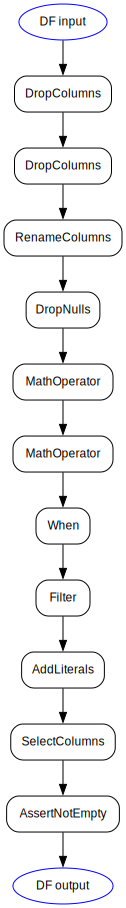

In [6]:
order_processing_pipeline.plot()

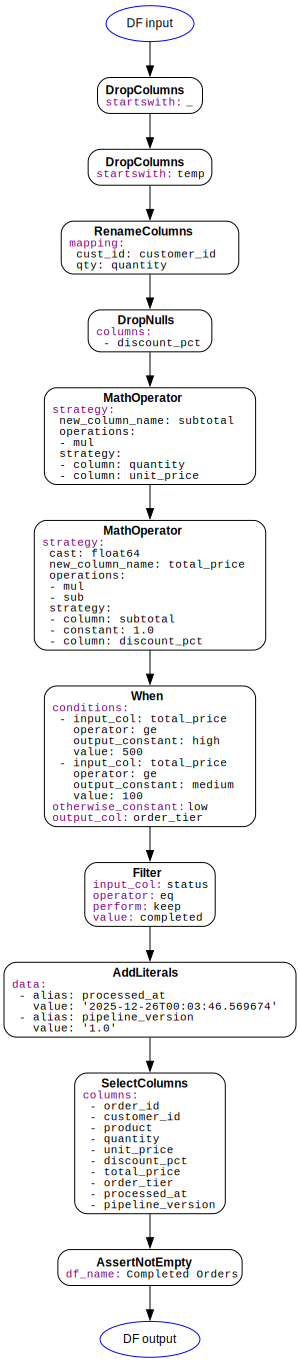

In [7]:
# With full details
order_processing_pipeline.plot(add_params=True)

## 3. Running the Pipeline

Use `run()` to execute the pipeline. The output dataframe type matches the input (Polars in, Polars out).

In [8]:
# Run the pipeline (showing the parameters)
processed_orders = order_processing_pipeline.run(orders_df, show_params=True)

print("Processed Orders:")
processed_orders

2025-12-26 00:04:07,413 | [INFO]: Starting pipeline 'Order Processing Pipeline' 
2025-12-26 00:04:07,417 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:04:07,464 | [INFO]: Completed 'DropColumns' in 0.1s 
2025-12-26 00:04:07,464 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:04:07,464 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:04:07,464 | [INFO]: Running 'RenameColumns' ... 
2025-12-26 00:04:07,480 | [INFO]: Completed 'RenameColumns' in 0.0s 
2025-12-26 00:04:07,480 | [INFO]: Running 'DropNulls' ... 
2025-12-26 00:04:07,483 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 00:04:07,483 | [INFO]: Running 'MathOperator' ... 
2025-12-26 00:04:07,499 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 00:04:07,500 | [INFO]: Running 'MathOperator' ... 
2025-12-26 00:04:07,500 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 00:04:07,500 | [INFO]: Running 'When' ... 
2025-12-26 00:04:07,500 | [INFO]: Completed 'When' in 0.0s 
2025-12-26 00:04:07,500 | [INFO]:

Processed Orders:


order_id,customer_id,product,quantity,unit_price,discount_pct,total_price,order_tier,processed_at,pipeline_version
i64,str,str,i64,f64,f64,f64,str,str,str
1001,"""C001""","""Laptop""",1,999.99,0.1,999.89,"""high""","""2025-12-26T00:03:46.569674""","""1.0"""
1002,"""C002""","""Mouse""",2,29.99,0.0,59.98,"""low""","""2025-12-26T00:03:46.569674""","""1.0"""
1003,"""C001""","""Keyboard""",1,79.99,0.05,79.94,"""low""","""2025-12-26T00:03:46.569674""","""1.0"""
1005,"""C002""","""Laptop""",1,1099.99,0.0,1099.99,"""high""","""2025-12-26T00:03:46.569674""","""1.0"""


## 4. Using Functions in Pipelines

Besides transformers, you can include **regular Python functions** in your pipeline. This is useful for:
- Quick one-off transformations
- Logging and debugging
- Integrating existing code

Functions must accept a dataframe as the first argument and return a dataframe.

In [10]:
def log_row_count(df):
    """Log the current row count for debugging."""
    print(f"  📊 Current row count: {len(df)}")
    return df


def add_revenue_flag(df, threshold: float):
    """Flag high-revenue orders above a threshold."""
    return df.with_columns(
        (pl.col("total_price") > threshold).alias("is_high_revenue")
    )


# Pipeline with functions
pipeline_with_functions = TransformerPipeline(
    [
        DropColumns(startswith="_"),
        DropColumns(startswith="temp"),
        
        # Simple function (just df -> df)
        log_row_count,
        
        DropNulls(columns=["discount_pct"]),
        
        log_row_count,  # Check count after dropping nulls
        
        MathOperator(strategy={
            "new_column_name": "total_price",
            "strategy": [
                {"column": "qty"},
                {"column": "unit_price"},
            ],
            "operations": ["mul"],
        }),
        
        # Function with arguments: use a tuple (func, [args], {kwargs})
        (add_revenue_flag, [], {"threshold": 200.0}),
        
        # You can also add a description as the 4th element
        # (func, [args], {kwargs}, "description")
    ],
    name="Pipeline with Functions",
)

In [11]:
pipeline_with_functions.show(add_params=True)

*** Pipeline with Functions *** (7 transformations)
 - DropColumns -> PARAMS: startswith="_"
 - DropColumns -> PARAMS: startswith="temp"
 - log_row_count
 - DropNulls -> PARAMS: columns=['discount_pct']
 - log_row_count
 - MathOperator -> PARAMS: strategy={'new_column_name': 'total_p ... unit_price'}], 'operations': ['mul']}
 - add_revenue_flag -> KWARGS={'threshold': 200.0}


In [12]:
result = pipeline_with_functions.run(orders_df)
print("\nResult:")
result

2025-12-26 00:04:53,406 | [INFO]: Starting pipeline 'Pipeline with Functions' 
2025-12-26 00:04:53,407 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:04:53,410 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:04:53,412 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:04:53,413 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:04:53,413 | [INFO]: Running 'log_row_count' ... 
2025-12-26 00:04:53,413 | [INFO]: Completed 'log_row_count' in 0.0s 
2025-12-26 00:04:53,413 | [INFO]: Running 'DropNulls' ... 
2025-12-26 00:04:53,420 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 00:04:53,421 | [INFO]: Running 'log_row_count' ... 
2025-12-26 00:04:53,422 | [INFO]: Completed 'log_row_count' in 0.0s 
2025-12-26 00:04:53,423 | [INFO]: Running 'MathOperator' ... 
2025-12-26 00:04:53,424 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 00:04:53,425 | [INFO]: Running 'add_revenue_flag' ... 
2025-12-26 00:04:53,426 | [INFO]: Completed 'add_revenue_flag' in 0.0s 
2025-12-2

  📊 Current row count: 8
  📊 Current row count: 7

Result:


order_id,cust_id,product,qty,unit_price,discount_pct,status,total_price,is_high_revenue
i64,str,str,i64,f64,f64,str,f64,bool
1001,"""C001""","""Laptop""",1,999.99,0.1,"""completed""",999.99,true
1002,"""C002""","""Mouse""",2,29.99,0.0,"""completed""",59.98,false
1003,"""C001""","""Keyboard""",1,79.99,0.05,"""completed""",79.99,false
1004,"""C003""","""Monitor""",1,299.99,0.15,"""pending""",299.99,true
1005,"""C002""","""Laptop""",1,1099.99,0.0,"""completed""",1099.99,true
1006,"""C004""","""Mouse""",5,24.99,0.2,"""cancelled""",124.95,false
1008,"""C005""","""Laptop""",1,899.99,0.1,"""pending""",899.99,true


## 5. Adding Descriptions to Transformers

For documentation and visualization, you can add descriptions to any transformer by wrapping it in a tuple: `(transformer, "description")`

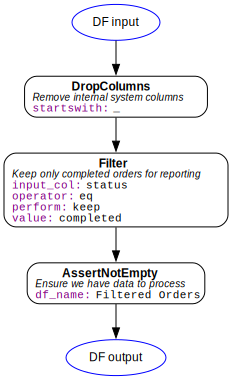

In [14]:
documented_pipeline = TransformerPipeline(
    [
        (DropColumns(startswith="_"), "Remove internal system columns"),
        (Filter(input_col="status", perform="keep", operator="eq", value="completed"), 
         "Keep only completed orders for reporting"),
        (AssertNotEmpty(df_name="Filtered Orders"), "Ensure we have data to process"),
    ],
    name="Documented Pipeline",
)

documented_pipeline.plot(add_params=True, add_description=True)

## 6. Nesting Pipelines

Pipelines can contain other pipelines, allowing you to organize complex transformations into logical, reusable stages.

In [15]:
# Stage 1: Data Cleaning
cleaning_stage = TransformerPipeline(
    [
        DropColumns(startswith="_"),
        DropColumns(startswith="temp"),
        RenameColumns(mapping={"cust_id": "customer_id", "qty": "quantity"}),
        DropNulls(columns=["discount_pct"]),
    ],
    name="🧹 Cleaning",
)

# Stage 2: Enrichment
enrichment_stage = TransformerPipeline(
    [
        MathOperator(strategy={
            "new_column_name": "total_price",
            "strategy": [
                {"column": "quantity"},
                {"column": "unit_price"},
                {"constant": 1.0},
                {"column": "discount_pct"},
            ],
            "operations": ["mul", "mul", "sub"],
        }),
        When(
            output_col="order_tier",
            conditions=[
                {"input_col": "total_price", "operator": "ge", "value": 500, "output_constant": "premium"},
                {"input_col": "total_price", "operator": "ge", "value": 100, "output_constant": "standard"},
            ],
            otherwise_constant="budget",
        ),
    ],
    name="✨ Enrichment",
)

# Stage 3: Filtering & Validation
validation_stage = TransformerPipeline(
    [
        Filter(input_col="status", perform="keep", operator="eq", value="completed"),
        AssertNotEmpty(df_name="Completed Orders"),
    ],
    name="✅ Validation",
)

# Master Pipeline: Compose the stages
master_pipeline = TransformerPipeline(
    [
        cleaning_stage,
        enrichment_stage,
        validation_stage,
    ],
    name="📦 Order Processing Master Pipeline",
)

In [16]:
# Visualize the nested structure
master_pipeline.show(add_params=True)

*** 📦 Order Processing Master Pipeline *** (8 transformations)
*** 🧹 Cleaning *** (4 transformations)
 - DropColumns -> PARAMS: startswith="_"
 - DropColumns -> PARAMS: startswith="temp"
 - RenameColumns -> PARAMS: mapping={'cust_id': 'customer_id', 'qty': 'quantity'}
 - DropNulls -> PARAMS: columns=['discount_pct']
*** ✨ Enrichment *** (2 transformations)
 - MathOperator -> PARAMS: strategy={'new_column_name': 'total_p ...  'operations': ['mul', 'mul', 'sub']}
 - When -> PARAMS: conditions=[{'input_col': 'total_pric ... ant="budget", output_col="order_tier"
*** ✅ Validation *** (2 transformations)
 - Filter -> PARAMS: input_col="status", operator="eq", perform="keep", value="completed"
 - AssertNotEmpty -> PARAMS: df_name="Completed Orders"


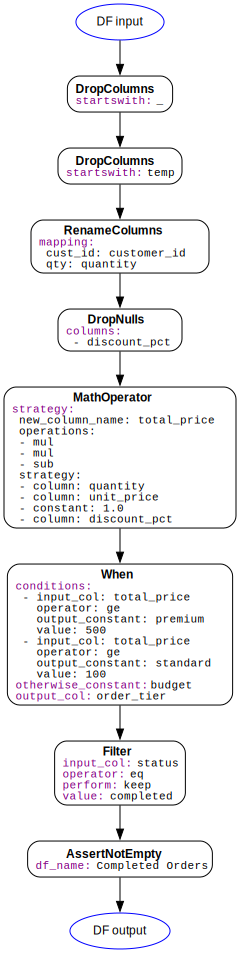

In [18]:
master_pipeline.plot(add_params=True, add_description=True)

In [19]:
# Run the complete pipeline
final_result = master_pipeline.run(orders_df)

print("Final Result:")
final_result

2025-12-26 00:05:39,955 | [INFO]: Starting pipeline '📦 Order Processing Master Pipeline' 
2025-12-26 00:05:39,958 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:05:39,961 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:05:39,962 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:05:39,964 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:05:39,965 | [INFO]: Running 'RenameColumns' ... 
2025-12-26 00:05:39,969 | [INFO]: Completed 'RenameColumns' in 0.0s 
2025-12-26 00:05:39,969 | [INFO]: Running 'DropNulls' ... 
2025-12-26 00:05:39,972 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 00:05:39,972 | [INFO]: Running 'MathOperator' ... 
2025-12-26 00:05:39,974 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 00:05:39,974 | [INFO]: Running 'When' ... 
2025-12-26 00:05:39,979 | [INFO]: Completed 'When' in 0.0s 
2025-12-26 00:05:39,980 | [INFO]: Running 'Filter' ... 
2025-12-26 00:05:39,983 | [INFO]: Completed 'Filter' in 0.0s 
2025-12-26 00:05:39,985 | [INFO]: Ru

Final Result:


order_id,customer_id,product,quantity,unit_price,discount_pct,status,total_price,order_tier
i64,str,str,i64,f64,f64,str,f64,str
1001,"""C001""","""Laptop""",1,999.99,0.1,"""completed""",999.89,"""premium"""
1002,"""C002""","""Mouse""",2,29.99,0.0,"""completed""",59.98,"""budget"""
1003,"""C001""","""Keyboard""",1,79.99,0.05,"""completed""",79.94,"""budget"""
1005,"""C002""","""Laptop""",1,1099.99,0.0,"""completed""",1099.99,"""premium"""


## 7. Reusing Pipeline Stages

One benefit of nested pipelines: stages can be reused across different master pipelines.

In [20]:
# Alternative pipeline: Same cleaning, but different downstream logic
analytics_pipeline = TransformerPipeline(
    [
        cleaning_stage,  # Reuse!
        enrichment_stage,  # Reuse!
        # Different: keep ALL orders for analytics (not just completed)
        SelectColumns(columns=["order_id", "customer_id", "total_price", "order_tier", "status"]),
    ],
    name="📊 Analytics Pipeline",
)

analytics_result = analytics_pipeline.run(orders_df)
print("Analytics Result (all orders):")
analytics_result

2025-12-26 00:05:42,233 | [INFO]: Starting pipeline '📊 Analytics Pipeline' 
2025-12-26 00:05:42,233 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:05:42,235 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:05:42,235 | [INFO]: Running 'DropColumns' ... 
2025-12-26 00:05:42,240 | [INFO]: Completed 'DropColumns' in 0.0s 
2025-12-26 00:05:42,240 | [INFO]: Running 'RenameColumns' ... 
2025-12-26 00:05:42,240 | [INFO]: Completed 'RenameColumns' in 0.0s 
2025-12-26 00:05:42,240 | [INFO]: Running 'DropNulls' ... 
2025-12-26 00:05:42,245 | [INFO]: Completed 'DropNulls' in 0.0s 
2025-12-26 00:05:42,245 | [INFO]: Running 'MathOperator' ... 
2025-12-26 00:05:42,246 | [INFO]: Completed 'MathOperator' in 0.0s 
2025-12-26 00:05:42,247 | [INFO]: Running 'When' ... 
2025-12-26 00:05:42,248 | [INFO]: Completed 'When' in 0.0s 
2025-12-26 00:05:42,249 | [INFO]: Running 'SelectColumns' ... 
2025-12-26 00:05:42,250 | [INFO]: Completed 'SelectColumns' in 0.0s 
2025-12-26 00:05:42,251 | [INFO]: Pi

Analytics Result (all orders):


order_id,customer_id,total_price,order_tier,status
i64,str,f64,str,str
1001,"""C001""",999.89,"""premium""","""completed"""
1002,"""C002""",59.98,"""budget""","""completed"""
1003,"""C001""",79.94,"""budget""","""completed"""
1004,"""C003""",299.84,"""standard""","""pending"""
1005,"""C002""",1099.99,"""premium""","""completed"""
1006,"""C004""",124.75,"""standard""","""cancelled"""
1008,"""C005""",899.89,"""premium""","""pending"""


## Summary

In this notebook you learned the fundamentals of Nebula flat pipelines:

| Concept | Description |
|---------|-------------|
| `TransformerPipeline([...], name="...")` | Create a pipeline from transformers and functions |
| `pipe.show()` | Print text representation (add `add_params=True` for details) |
| `pipe.plot()` | Render as DAG diagram (requires Graphviz + pyyaml) |
| `pipe.run(df)` | Execute the pipeline on a dataframe |
| `(transformer, "description")` | Add documentation to a transformer |
| `(func, [args], {kwargs})` | Include functions with arguments |
| Nested pipelines | Organize complex workflows into reusable stages |

**Transformers used in this notebook:**
- `SelectColumns`, `DropColumns`, `RenameColumns` — column manipulation
- `Filter`, `DropNulls` — row filtering
- `MathOperator` — calculations across columns
- `When` — conditional column creation
- `AddLiterals` — add constant values
- `AssertNotEmpty` — validation

**Next notebooks:**
- **Split Pipelines** — parallel processing branches
- **Branching & Row Operations** — forking, apply_to_rows, skip options
- **Storage & Runtime Dynamics** — caching, LazyTransformer, debugging
- **JSON/YAML Configuration** — declarative pipeline definitions